In [19]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import os
import numpy as np
import matplotlib.pyplot as plt

In [20]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [256, 256])  # Resize to 256x256
    img = (img / 127.5) - 1  # Normalize to [-1, 1]
    return img

def load_data(input_dir, output_dir):
    input_images = sorted([os.path.join(input_dir, img) for img in os.listdir(input_dir)])
    output_images = sorted([os.path.join(output_dir, img) for img in os.listdir(output_dir)])

    dataset = tf.data.Dataset.from_tensor_slices((input_images, output_images))

    def map_func(input_path, output_path):
        input_img = load_image(input_path)
        output_img = load_image(output_path)
        return input_img, output_img

    return dataset.map(map_func).batch(16)  # Batch size 16

In [21]:
LAMBDA = 100  # Weight for L1 loss

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_loss = gan_loss + (LAMBDA * l1_loss)
    return total_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_loss = real_loss + generated_loss
    return total_loss

In [22]:
@tf.function
def train_step(input_image, target, generator, discriminator, gen_optimizer, disc_optimizer):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Forward pass
        generated_image = generator(input_image, training=True)

        # Discriminator outputs
        real_output = discriminator([input_image, target], training=True)
        fake_output = discriminator([input_image, generated_image], training=True)

        # Loss calculations
        gen_loss = generator_loss(fake_output, generated_image, target)  # Generator loss (e.g., GAN + L1 loss)
        disc_loss = discriminator_loss(real_output, fake_output)         # Discriminator loss

    # Apply gradients
    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    # Return losses
    return gen_loss, disc_loss

# Instantiate optimizers
gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)



In [23]:
import tensorflow as tf
from tensorflow.keras import layers

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        layers.Conv2D(filters, size, strides=2, padding='same',
                      kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        layers.Conv2DTranspose(filters, size, strides=2,
                               padding='same',
                               kernel_initializer=initializer,
                               use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')  # (bs, 256, 256, 3)
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [24]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [25]:
import os
import shutil
import random

# Define paths
dataset_path = "dataset"
input_dir = os.path.join(dataset_path, "input")
output_dir = os.path.join(dataset_path, "output")

# Output directories for splits
train_input_dir = os.path.join(dataset_path, "train/input")
train_output_dir = os.path.join(dataset_path, "train/output")
test_input_dir = os.path.join(dataset_path, "test/input")
test_output_dir = os.path.join(dataset_path, "test/output")

# Create directories for train and test sets
os.makedirs(train_input_dir, exist_ok=True)
os.makedirs(train_output_dir, exist_ok=True)
os.makedirs(test_input_dir, exist_ok=True)
os.makedirs(test_output_dir, exist_ok=True)

# Set train-test split ratio
split_ratio = 0.8  # 80% train, 20% test

# Get all files in the input directory
input_files = [f for f in os.listdir(input_dir) if f.startswith("input_")]
input_files.sort()  # Ensure files are sorted to align with output files

# Shuffle files randomly (optional)
random.seed(42)  # For reproducibility
random.shuffle(input_files)

# Calculate split index
split_index = int(len(input_files) * split_ratio)

# Split into train and test
train_files = input_files[:split_index]
test_files = input_files[split_index:]

# Move files to train and test directories
for file in train_files:
    number = file.split("_")[1]  # Extract the number from 'input_<number>'
    shutil.copy(os.path.join(input_dir, file), os.path.join(train_input_dir, file))
    shutil.copy(os.path.join(output_dir, f"output_{number}"), os.path.join(train_output_dir, f"output_{number}"))

for file in test_files:
    number = file.split("_")[1]
    shutil.copy(os.path.join(input_dir, file), os.path.join(test_input_dir, file))
    shutil.copy(os.path.join(output_dir, f"output_{number}"), os.path.join(test_output_dir, f"output_{number}"))

print("Dataset successfully split into train and test sets!")

Dataset successfully split into train and test sets!


In [26]:
generator = Generator()
discriminator = Discriminator()
discriminator.summary()

Model: "functional_99"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_image (InputLayer) │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_39            │ (None, 256, 256, 6)    │              0 │ input_image[0][0],     │
│ (Concatenate)             │                        │                │ target_image[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_87             │ (None, 128, 128, 64)   │          6,144 │ concatenate_39[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_88             │ (None, 64, 64, 128)    │        131,584 │ sequential_87[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_89             │ (None, 32, 32, 256)    │        525,312 │ sequential_88[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_8          │ (None, 34, 34, 256)    │              0 │ sequential_89[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_63 (Conv2D)        │ (None, 31, 31, 512)    │      2,097,152 │ zero_padding2d_8[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_84    │ (None, 31, 31, 512)    │          2,048 │ conv2d_63[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_59            │ (None, 31, 31, 512)    │              0 │ batch_normalization_8… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_9          │ (None, 33, 33, 512)    │              0 │ leaky_re_lu_59[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_64 (Conv2D)        │ (None, 30, 30, 1)      │          8,193 │ zero_padding2d_9[0][0] │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,770,433 (10.57 MB)

 Trainable params: 2,768,641 (10.56 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [27]:


train_dataset = load_data(train_input_dir, train_output_dir)

EPOCHS = 300

for epoch in range(EPOCHS):
    gen_loss_epoch = []
    disc_loss_epoch = []

    for step, (input_image, target) in enumerate(train_dataset):
        # Perform training step and calculate losses
        gen_loss, disc_loss = train_step(input_image, target, generator, discriminator, gen_optimizer, disc_optimizer)

        # Append losses for tracking
        gen_loss_epoch.append(gen_loss)
        disc_loss_epoch.append(disc_loss)

        # Optionally print step-level metrics
        if step % 100 == 0:  # Print every 100 steps
            print(f"Epoch {epoch+1}, Step {step}: Generator Loss = {gen_loss:.4f}, Discriminator Loss = {disc_loss:.4f}")

    # Calculate and display epoch-level metrics
    mean_gen_loss = sum(gen_loss_epoch) / len(gen_loss_epoch)
    mean_disc_loss = sum(disc_loss_epoch) / len(disc_loss_epoch)
    print(f"Epoch {epoch+1} Completed: Mean Generator Loss = {mean_gen_loss:.4f}, Mean Discriminator Loss = {mean_disc_loss:.4f}")

generator.save_weights('generator_weights.weights.h5')  # Added '.weights' to the filename
discriminator.save_weights('discriminator_weights.weights.h5') # Added '.weights' to the filename

Epoch 1, Step 0: Generator Loss = 67.6093, Discriminator Loss = 1.6731
Epoch 1 Completed: Mean Generator Loss = 52.0250, Mean Discriminator Loss = 1.8144
Epoch 2, Step 0: Generator Loss = 41.6653, Discriminator Loss = 1.0700
Epoch 2 Completed: Mean Generator Loss = 31.1641, Mean Discriminator Loss = 0.9591
Epoch 3, Step 0: Generator Loss = 24.6344, Discriminator Loss = 0.9291
Epoch 3 Completed: Mean Generator Loss = 17.2802, Mean Discriminator Loss = 1.1551
Epoch 4, Step 0: Generator Loss = 13.6651, Discriminator Loss = 0.9256
Epoch 4 Completed: Mean Generator Loss = 11.1187, Mean Discriminator Loss = 0.8919
Epoch 5, Step 0: Generator Loss = 10.1085, Discriminator Loss = 0.6409
Epoch 5 Completed: Mean Generator Loss = 9.9254, Mean Discriminator Loss = 0.7177
Epoch 6, Step 0: Generator Loss = 9.1221, Discriminator Loss = 0.5511
Epoch 6 Completed: Mean Generator Loss = 9.6832, Mean Discriminator Loss = 0.6874
Epoch 7, Step 0: Generator Loss = 9.0657, Discriminator Loss = 0.3726
Epoch 7 C

In [28]:
generator.save_weights('generator_weights.weights.h5')  # Added '.weights' to the filename
discriminator.save_weights('discriminator_weights.weights.h5') # Added '.weights' to the filename

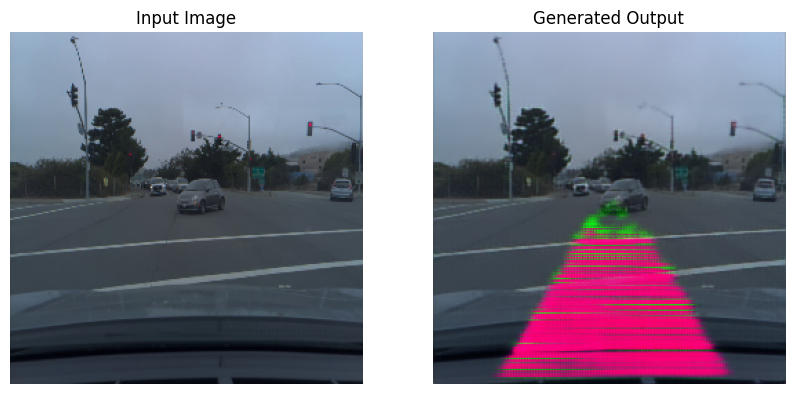

In [30]:
from tensorflow.keras.models import load_model

# Rebuild generator and discriminator
generator = Generator()  # Use the same generator architecture
discriminator = Discriminator()  # Use the same discriminator architecture

# Load weights
generator.load_weights('generator_weights.weights.h5')
discriminator.load_weights('discriminator_weights.weights.h5')# Helper function to preprocess the image

def preprocess_image(image_path):
    """Load and preprocess an image."""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)  # Adjust to your image type (e.g., PNG, JPEG)
    image = tf.image.resize(image, [256, 256])  # Resize to match training dimensions
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return tf.expand_dims(image, axis=0)  # Add batch dimension

# Helper function to postprocess the output
def postprocess_output(output):
    """Convert model output to a displayable image."""
    output = (output + 1) * 127.5  # De-normalize to [0, 255]
    output = tf.cast(output, tf.uint8)
    return tf.squeeze(output, axis=0)  # Remove batch dimension

# Path to your input image
test_image_path = "/content/dataset/input/input_13.png"

# Preprocess the image
test_image = preprocess_image(test_image_path)

# Generate the output using the trained generator
generated_image = generator(test_image, training=False)

# Postprocess the output
output_image = postprocess_output(generated_image)

# Display the input and generated output
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(tf.squeeze(test_image, axis=0) * 0.5 + 0.5)  # De-normalize for display
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Generated Output")
plt.imshow(output_image)
plt.axis("off")

plt.show()